In [1]:
import pandas as pd
import requests
import json
import numpy as np

In [2]:
# the NOAA api pull code was aquired from Professor Michael Bush at Regis University

# smy credentials for NOAA API. 
token = 'yEpCYKpOwkhOJBmuoHbpEGGKpYKXXmtg'

In [3]:
# variables based on my station search
network = 'GHCND'
ID = 'USW00094728'
station_id = network + ':' + ID
print(station_id)

GHCND:USW00094728


In [4]:
data = {}
data = {'limit':'1000', 'datasetid': network, 'stationid': station_id}

In [5]:
# append additional parameters to data dictionary
data.update({'datatypeid': 'prcp'})
data.update({'startdate': '2019-01-01'})
data.update({'enddate': '2019-12-31'})
data.update({'units':'standard'})
data

{'limit': '1000',
 'datasetid': 'GHCND',
 'stationid': 'GHCND:USW00094728',
 'datatypeid': 'prcp',
 'startdate': '2019-01-01',
 'enddate': '2019-12-31',
 'units': 'standard'}

In [6]:
# make the request to get our year of data
t = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})

#load the api response as a json
Precip = json.loads(t.text)

#Build the initial dataframe
df=pd.json_normalize(Precip, 'results')

#Rename the column with the values to the datatype and remove the excess values
df=df.rename(columns = {'value':'PRCP'})
df.drop(['attributes','datatype'], axis=1, inplace=True)

In [7]:
#Verify our dataframe
df.head()

,date,station,PRCP
0,2019-01-01T00:00:00,GHCND:USW00094728,0.06
1,2019-01-02T00:00:00,GHCND:USW00094728,0.00
2,2019-01-03T00:00:00,GHCND:USW00094728,0.00
3,2019-01-04T00:00:00,GHCND:USW00094728,0.00
4,2019-01-05T00:00:00,GHCND:USW00094728,0.50


In [8]:
#Build our dataframe to include the additional required parameters

types = ['tmax','tmin']

for i in types:
    data.update({'datatypeid': i})
    j = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})
    o = json.loads(j.text)
        
    #create new dataframe with api results
    df2 = pd.json_normalize(o, 'results')
    df2=df2.rename(columns = {'value':i})
    df2.drop(['station','attributes','datatype'], axis=1, inplace=True)
    
    #merge the new dataframe with the base one on the date column
    df = pd.merge(df, df2, on=['date'], how='outer')

In [9]:
df.head()

,date,station,PRCP,tmax,tmin
0,2019-01-01T00:00:00,GHCND:USW00094728,0.06,58.0,39.0
1,2019-01-02T00:00:00,GHCND:USW00094728,0.00,40.0,35.0
2,2019-01-03T00:00:00,GHCND:USW00094728,0.00,44.0,37.0
3,2019-01-04T00:00:00,GHCND:USW00094728,0.00,47.0,35.0
4,2019-01-05T00:00:00,GHCND:USW00094728,0.50,47.0,41.0


In [10]:
#Build our our dataframe to include previous years
data.update({'datatypeid': 'prcp'})
dates = ['2018','2017','2016','2015','2014','2013','2012','2011','2010','2009']

for d in dates:
    
    #set the start and end dates
    sd = f'{d}-01-01'
    ed = f'{d}-12-31'
    data.update({'startdate': sd})
    data.update({'enddate': ed})

    #Call to api to get results
    j = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})
    o = json.loads(j.text)
        
    #create new dataframe with api results
    df2 = pd.json_normalize(o, 'results')
    df2=df2.rename(columns = {'value':'PRCP'})
    df2.drop(['attributes','datatype'], axis=1, inplace=True)
    
    #add data for each of the datatypes
    types = ['tmax','tmin']

    for i in types:
        data.update({'datatypeid': i})
        
        #Call to api to get results
        j = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})
        o = json.loads(j.text)
        
        #create new dataframe with api results
        df3 = pd.json_normalize(o, 'results')
        df3=df3.rename(columns = {'value':i})
        df3.drop(['station','attributes','datatype'], axis=1, inplace=True)
    
        #merge the new dataframe with the base one on the date column
        df2 = pd.merge(df2, df3, on=['date'], how='outer')
    
    #merge the new dataframe with the base one on the date column
    df = pd.concat([df, df2])
    

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4017 entries, 0 to 364
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     4017 non-null   object 
 1   station  4017 non-null   object 
 2   PRCP     4017 non-null   float64
 3   tmax     4017 non-null   float64
 4   tmin     4017 non-null   float64
dtypes: float64(3), object(2)
memory usage: 188.3+ KB


In [12]:
#Create a column with the date
df['datetime']=pd.to_datetime(df['date'])
#Create a column with the week number for the year
df['week']=df['datetime'].dt.isocalendar().week
#then drop the older date column
df.drop(['date'], axis=1, inplace=True)

In [13]:
df.to_csv('weatherNY.csv', index=False)

In [14]:
weatherNY=pd.read_csv('weatherNY.csv')

In [15]:
weatherNY['datetime'] = weatherNY['datetime'].astype('datetime64[ns]')

In [16]:
weatherNY.describe()

,PRCP,tmax,tmin,week
count,4017.000000,4017.000000,4017.000000,4017.000000
mean,40.131337,63.149614,49.008962,26.598706
std,24.161575,18.321940,16.784785,15.061652
min,-1.000000,13.000000,-1.000000,1.000000
25%,24.000000,48.000000,36.000000,14.000000
50%,43.000000,65.000000,50.000000,27.000000
75%,61.000000,79.000000,64.000000,40.000000
max,84.000000,104.000000,84.000000,53.000000


In [17]:
import math

# We need to remove that negative precipitation record
weatherNY.loc[(weatherNY.PRCP < 0),'PRCP']=0

# and handle the outliers above 2 inches
weatherNY.loc[(weatherNY.PRCP > 2),'PRCP']=np.log(weatherNY['PRCP'])

weatherNY.fillna(weatherNY.mean(), inplace=True)

C:\Users\eesti\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\eesti\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  if __name__ == '__main__':


In [18]:
weekly_avg = weatherNY.resample('W-Sat', label='right', closed = 'right', on='datetime').mean().reset_index().sort_values(by='datetime')

In [19]:
weekly_avg.head()

,datetime,PRCP,tmax,tmin,week
0,2009-01-03,3.070280,32.666667,22.333333,1.000000
1,2009-01-10,3.355046,37.285714,29.000000,1.857143
2,2009-01-17,2.717772,28.714286,17.000000,2.857143
3,2009-01-24,3.055675,36.142857,21.714286,3.857143
4,2009-01-31,3.059749,32.000000,21.857143,4.857143


In [20]:
weekly_avg.rename({'PRCP': 'avgPrecip', 'awnd': 'avgAwnd', 'tmax': 'avgTmax', 'tmin':'avgTmin'}, axis=1, inplace=True)

In [21]:
weekly_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 0 to 574
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   575 non-null    datetime64[ns]
 1   avgPrecip  575 non-null    float64       
 2   avgTmax    575 non-null    float64       
 3   avgTmin    575 non-null    float64       
 4   week       575 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 27.0 KB


In [22]:
from datetime import date, timedelta

weekly_avg['date'] = weekly_avg['datetime']

# Drop the old date column and the week column
weekly_avg.drop(['datetime','week'], axis=1, inplace=True)

In [23]:
weekly_avg.isna().sum()

avgPrecip    0
avgTmax      0
avgTmin      0
date         0
dtype: int64

In [24]:
weekly_avg.describe()

,avgPrecip,avgTmax,avgTmin
count,575.000000,575.000000,575.000000
mean,3.148576,63.099627,48.970849
std,1.458037,17.169515,15.977568
min,0.000000,22.428571,9.000000
25%,3.208540,48.214286,35.857143
50%,3.748578,64.142857,48.857143
75%,4.097442,78.928571,63.500000
max,4.368824,95.714286,79.000000


In [25]:
# convert from avg precipitation per week to total for the week
weekly_avg['totPrecip']= weekly_avg.avgPrecip * 7
weekly_avg.drop(['avgPrecip'], axis=1, inplace=True)

In [26]:
flu=pd.read_csv('NY_FLU.csv')

In [27]:
flu.head()

,Season,Region,County,CDC Week,Week Ending Date,Disease,Count,County Centroid,FIPS
0,2010-2011,NYC,NEW YORK,46,11/20/2010,INFLUENZA_A,15,"(40.7831, -73.9712)",36061
1,2010-2011,NYC,NEW YORK,50,12/18/2010,INFLUENZA_B,0,"(40.7831, -73.9712)",36061
2,2010-2011,NYC,RICHMOND,41,10/16/2010,INFLUENZA_A,0,"(40.5795, -74.1502)",36085
3,2011-2012,NYC,KINGS,42,10/22/2011,INFLUENZA_A,0,"(40.6782, -73.9442)",36047
4,2012-2013,WESTERN,SENECA,14,04/06/2013,INFLUENZA_A,0,"(42.7652, -76.8721)",36099


### Because this is a New York State dataset we are going to drop all records that are not from the New York City area.

In [28]:
flu.drop(flu.loc[flu['Region']=='CAPITAL DISTRICT'].index, inplace=True)
flu.drop(flu.loc[flu['Region']=='CENTRAL'].index, inplace=True)
flu.drop(flu.loc[flu['Region']=='WESTERN'].index, inplace=True)

In [29]:
flu.sort_values(by='Week Ending Date')

,Season,Region,County,CDC Week,Week Ending Date,Disease,Count,County Centroid,FIPS
3119,2010-2011,METRO,SULLIVAN,52,01/01/2011,INFLUENZA_B,0,"(41.7201763, -74.7646796)",36105
7223,2010-2011,METRO,ORANGE,52,01/01/2011,INFLUENZA_B,0,"(41.4024096, -74.3062522)",36071
27347,2010-2011,NYC,NEW YORK,52,01/01/2011,INFLUENZA_B,6,"(40.7831, -73.9712)",36061
347,2010-2011,NYC,QUEENS,52,01/01/2011,INFLUENZA_UNSPECIFIED,1,"(40.7282, -73.7949)",36081
4338,2010-2011,NYC,KINGS,52,01/01/2011,INFLUENZA_A,74,"(40.6782, -73.9442)",36047
...,...,...,...,...,...,...,...,...,...
34689,2016-2017,METRO,DUTCHESS,52,12/31/2016,INFLUENZA_UNSPECIFIED,0,"(41.7550085, -73.7399512)",36027
46557,2016-2017,METRO,WESTCHESTER,52,12/31/2016,INFLUENZA_UNSPECIFIED,0,"(41.1527698, -73.745912)",36119
37148,2016-2017,METRO,WESTCHESTER,52,12/31/2016,INFLUENZA_A,237,"(41.1527698, -73.745912)",36119
48282,2016-2017,METRO,NASSAU,52,12/31/2016,INFLUENZA_B,7,"(40.7506561, -73.582905)",36059


In [30]:
# Drop the columns that are not relevant to our analysis
flu.drop(['Season','Region','FIPS','County Centroid','Disease'], axis=1, inplace=True)

In [31]:
# Change the date column to align with the weather data
flu.rename({'Week Ending Date': 'date'}, axis=1, inplace=True)

In [32]:
# Convert the date to datetime
flu['date'] = flu['date'].astype('datetime64[ns]')

In [33]:
# Join all of the weekly data together into a single record
flu_group = flu.groupby(['date'])
flu_sum=flu_group.sum().reset_index()

In [34]:
flu_sum.head()

,date,CDC Week,Count
0,2009-10-10,1680,131
1,2009-10-17,1722,161
2,2009-10-24,1764,394
3,2009-10-31,1806,837
4,2009-11-07,1848,1365


In [35]:
flu_weatherNY=pd.merge(flu_sum, weekly_avg, on=['date'], how='outer')

In [36]:
flu_weatherNY.head()

,date,CDC Week,Count,avgTmax,avgTmin,totPrecip
0,2009-10-10,1680.0,131.0,67.714286,54.000000,27.909222
1,2009-10-17,1722.0,161.0,53.571429,41.714286,26.091560
2,2009-10-24,1764.0,394.0,62.285714,47.285714,26.933492
3,2009-10-31,1806.0,837.0,60.142857,50.571429,27.454713
4,2009-11-07,1848.0,1365.0,54.428571,41.857143,26.099169


In [37]:
flu_weatherNY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 590
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       591 non-null    datetime64[ns]
 1   CDC Week   359 non-null    float64       
 2   Count      359 non-null    float64       
 3   avgTmax    575 non-null    float64       
 4   avgTmin    575 non-null    float64       
 5   totPrecip  575 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 32.3 KB


In [38]:
flu_weatherNY.isna().sum()

date           0
CDC Week     232
Count        232
avgTmax       16
avgTmin       16
totPrecip     16
dtype: int64

### The CDC data only covers the flu season while the weather data covers the entire years. This means we will have some null values for both count and CDC week as we see above. We need to remove these record.

In [39]:
# Drop the weeks where CDC week is null
flu_weatherNY = flu_weatherNY[flu_weatherNY['CDC Week'].notna()]

In [40]:
# Fill forward the remaining na values
flu_weatherNY.fillna(method='ffill', inplace=True)

In [41]:
flu_weatherNY.isna().sum()

date         0
CDC Week     0
Count        0
avgTmax      0
avgTmin      0
totPrecip    0
dtype: int64

In [42]:
# Remove the columns that we won't need for our analysis (date and CDC Week)
flu_weatherNY.drop(['CDC Week'], axis=1, inplace=True)

In [43]:
flu_weatherNY.describe()

,Count,avgTmax,avgTmin,totPrecip
count,359.000000,359.000000,359.000000,359.000000
mean,1153.782730,52.512137,39.280143,19.887209
std,2008.088974,12.056341,10.671412,10.238992
min,6.000000,22.428571,9.000000,0.000000
25%,64.500000,43.333333,31.785714,20.376058
50%,305.000000,52.142857,38.571429,24.737350
75%,1289.000000,62.714286,47.285714,26.663454
max,11992.000000,79.428571,62.428571,28.892796


In [44]:
flu_weatherNY.head()

,date,Count,avgTmax,avgTmin,totPrecip
0,2009-10-10,131.0,67.714286,54.000000,27.909222
1,2009-10-17,161.0,53.571429,41.714286,26.091560
2,2009-10-24,394.0,62.285714,47.285714,26.933492
3,2009-10-31,837.0,60.142857,50.571429,27.454713
4,2009-11-07,1365.0,54.428571,41.857143,26.099169


Text(0.5, 1.0, 'Weekly Precipitation vs Positive Flu Cases NYC')

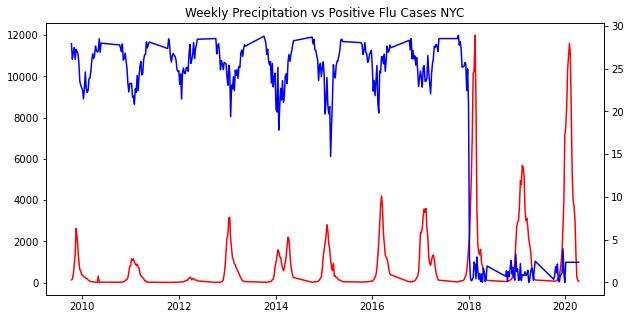

In [45]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(frameon=False)
ax2=ax.twinx()

ax.plot(flu_weatherNY['date'], flu_weatherNY['Count'], color='r')
ax2.plot(flu_weatherNY['date'], flu_weatherNY['totPrecip'], color='b')

# set title
plt.title('Weekly Precipitation vs Positive Flu Cases NYC')

Text(0.5, 1.0, 'Avg Maximum Temp vs Positive Flu Cases NYC')

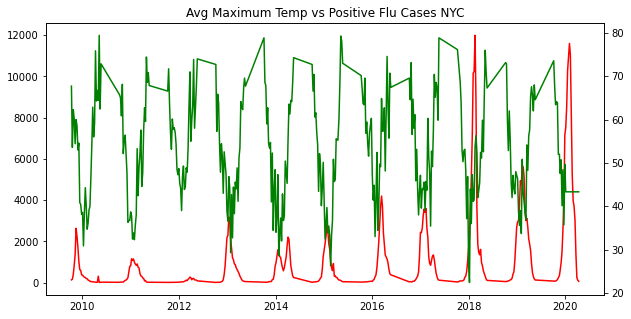

In [46]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(frameon=False)
ax2=ax.twinx()

ax.plot(flu_weatherNY['date'], flu_weatherNY['Count'], color='r')
ax2.plot(flu_weatherNY['date'], flu_weatherNY['avgTmax'], color='g')

# set title
plt.title('Avg Maximum Temp vs Positive Flu Cases NYC')

Text(0.5, 1.0, 'Avg Minimum Temp vs Positive Flu Cases NYC')

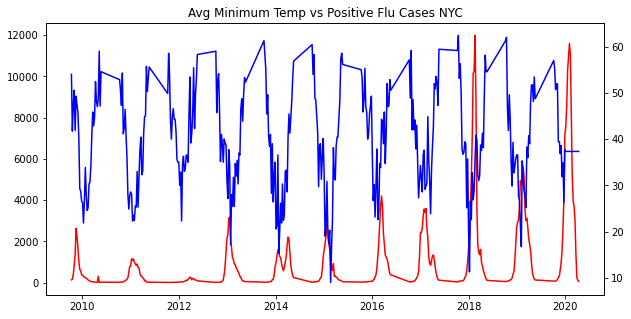

In [47]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(frameon=False)
ax2=ax.twinx()

ax.plot(flu_weatherNY['date'], flu_weatherNY['Count'], color='r')
ax2.plot(flu_weatherNY['date'], flu_weatherNY['avgTmin'], color='b')

# set title
plt.title('Avg Minimum Temp vs Positive Flu Cases NYC')

### Now we will add an additional location in Luxembourg

In [48]:
# variables based on my station search
network = 'GHCND'
ID = 'LU000006590'
station_id = network + ':' + ID
print(station_id)

GHCND:LU000006590


In [49]:
data = {}
data = {'limit':'1000', 'datasetid': network, 'stationid': station_id}

In [50]:
# append additional parameters to data dictionary
data.update({'datatypeid': 'prcp'})
data.update({'startdate': '2019-01-01'})
data.update({'enddate': '2019-12-31'})
data

{'limit': '1000',
 'datasetid': 'GHCND',
 'stationid': 'GHCND:LU000006590',
 'datatypeid': 'prcp',
 'startdate': '2019-01-01',
 'enddate': '2019-12-31'}

In [51]:
# make the request to get our year of data
t = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})

#load the api response as a json
Precip = json.loads(t.text)

#Build the initial dataframe
df=pd.json_normalize(Precip, 'results')

#Rename the column with the values to the datatype and remove the excess values
df=df.rename(columns = {'value':'PRCP'})
df.drop(['attributes','datatype'], axis=1, inplace=True)

In [52]:
df.head()

,date,station,PRCP
0,2019-01-01T00:00:00,GHCND:LU000006590,13
1,2019-01-02T00:00:00,GHCND:LU000006590,0
2,2019-01-03T00:00:00,GHCND:LU000006590,0
3,2019-01-04T00:00:00,GHCND:LU000006590,13
4,2019-01-05T00:00:00,GHCND:LU000006590,6


In [53]:
#Build our dataframe to include the additional required parameters

types = ['tmax','tmin']

for i in types:
    data.update({'datatypeid': i})
    j = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})
    o = json.loads(j.text)
        
    #create new dataframe with api results
    df2 = pd.json_normalize(o, 'results')
    df2=df2.rename(columns = {'value':i})
    df2.drop(['station','attributes','datatype'], axis=1, inplace=True)
    
    #merge the new dataframe with the base one on the date column
    df = pd.merge(df, df2, on=['date'], how='outer')

In [54]:
#Build our our dataframe to include previous years
data.update({'datatypeid': 'prcp'})
dates = ['2018','2017','2016','2015','2014','2013','2012','2011','2010','2009']


for d in dates:
    
    #set the start and end dates
    sd = f'{d}-01-01'
    ed = f'{d}-12-31'
    data.update({'startdate': sd})
    data.update({'enddate': ed})

    #Call to api to get results
    j = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})
    o = json.loads(j.text)
        
    #create new dataframe with api results
    df2 = pd.json_normalize(o, 'results')
    df2=df2.rename(columns = {'value':'PRCP'})
    df2.drop(['attributes','datatype'], axis=1, inplace=True)
    
    #add data for each of the datatypes
    types = ['tmax','tmin']

    for i in types:
        data.update({'datatypeid': i})
        
        #Call to api to get results
        j = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})
        o = json.loads(j.text)
        
        #create new dataframe with api results
        df3 = pd.json_normalize(o, 'results')
        df3=df3.rename(columns = {'value':i})
        df3.drop(['station','attributes','datatype'], axis=1, inplace=True)
    
        #merge the new dataframe with the base one on the date column
        df2 = pd.merge(df2, df3, on=['date'], how='outer')
    
    #merge the new dataframe with the base one on the date column
    df = pd.concat([df, df2])

In [55]:
df.head()

,date,station,PRCP,tmax,tmin
0,2019-01-01T00:00:00,GHCND:LU000006590,13,57,24
1,2019-01-02T00:00:00,GHCND:LU000006590,0,32,-21
2,2019-01-03T00:00:00,GHCND:LU000006590,0,33,-33
3,2019-01-04T00:00:00,GHCND:LU000006590,13,30,-13
4,2019-01-05T00:00:00,GHCND:LU000006590,6,45,1


In [56]:
#Create a column with the date
df['datetime']=pd.to_datetime(df['date'])
#Create a column with the week number for the year
df['week']=df['datetime'].dt.isocalendar().week
#then drop the older date column
df.drop(['date'], axis=1, inplace=True)

In [57]:
weatherLux = df

In [58]:
weatherLux.to_csv('weatherLux.csv', index=False)

In [59]:
weatherLux=pd.read_csv('weatherLux.csv')

In [60]:
weatherLux['datetime'] = weatherLux['datetime'].astype('datetime64[ns]')

In [61]:
weatherLux.describe()

,PRCP,tmax,tmin,week
count,4017.000000,4017.000000,4017.000000,4017.000000
mean,54.742096,140.822255,63.466019,26.598706
std,62.961881,85.544755,64.060315,15.061652
min,-150.000000,-80.000000,-150.000000,1.000000
25%,1.000000,73.000000,15.000000,14.000000
50%,49.000000,143.000000,65.000000,27.000000
75%,103.000000,206.000000,114.000000,40.000000
max,419.000000,390.000000,241.000000,53.000000


In [62]:
# we have extraneous precipitation and temperature numbers that need to be addressed based on a record high of 102° and 
# a record low of -4.4° I am going to keep all values between -2° and 100°. I will change the outliers to NaN and then
# do a forward fill.

# deal with the minimum values
weatherLux.loc[(weatherLux.PRCP < 0),'PRCP']=0
weatherLux.loc[(weatherLux.tmax < 0),'tmax']=np.nan
weatherLux.loc[(weatherLux.tmin < -2),'tmin']=np.nan

# deal with the maximum values
weatherLux.loc[(weatherLux.PRCP > 1),'PRCP']=np.nan
weatherLux.loc[(weatherLux.tmax > 100),'tmax']=np.nan
weatherLux.loc[(weatherLux.tmin > 80),'tmin']=np.nan

In [63]:
weatherLux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4017 entries, 0 to 4016
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   station   4017 non-null   object        
 1   PRCP      1021 non-null   float64       
 2   tmax      1275 non-null   float64       
 3   tmin      1681 non-null   float64       
 4   datetime  4017 non-null   datetime64[ns]
 5   week      4017 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 188.4+ KB


In [64]:
weatherLux.isna().sum()

station        0
PRCP        2996
tmax        2742
tmin        2336
datetime       0
week           0
dtype: int64

In [65]:
# Fill the remaining na values utilizing the mean value for each column
weatherLux.fillna(weatherLux.mean(), inplace=True)


C:\Users\eesti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


In [66]:
# WHO data weeks end on Sunday, so we need to modify the date
weekly_avg = weatherLux.resample('W-Sun', label='right', closed = 'right', on='datetime').mean().reset_index().sort_values(by='datetime')

In [67]:
weekly_avg.rename({'PRCP': 'avgPrecip', 'awnd': 'avgAwnd', 'tmax': 'avgTmax', 'tmin':'avgTmin'}, axis=1, inplace=True)

In [68]:
weekly_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 0 to 574
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   575 non-null    datetime64[ns]
 1   avgPrecip  575 non-null    float64       
 2   avgTmax    575 non-null    float64       
 3   avgTmin    575 non-null    float64       
 4   week       575 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 27.0 KB


In [69]:
weekly_avg['date'] = weekly_avg['datetime']

# Drop the old date column and the week column
weekly_avg.drop(['datetime','week'], axis=1, inplace=True)

In [70]:
weekly_avg.isna().sum()

avgPrecip    0
avgTmax      0
avgTmin      0
date         0
dtype: int64

In [71]:
# convert from avg precipitation per week to total for the week
weekly_avg['totPrecip']= weekly_avg.avgPrecip * 7
weekly_avg.drop(['avgPrecip'], axis=1, inplace=True)

In [72]:
flu = pd.read_csv('LUX_Flu.csv')

In [73]:
flu.head()

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,Luxembourg,European Region of WHO,South West Europe,2009,1,12/29/2008,1/4/2009,NaN,11.0,NaN,...,NaN,4.0,4.0,NaN,NaN,NaN,NaN,4.0,NaN,Regional Outbreak
1,Luxembourg,European Region of WHO,South West Europe,2009,2,1/5/2009,1/11/2009,NaN,28.0,NaN,...,NaN,15.0,15.0,NaN,NaN,NaN,NaN,15.0,NaN,Widespread Outbreak
2,Luxembourg,European Region of WHO,South West Europe,2009,3,1/12/2009,1/18/2009,NaN,92.0,NaN,...,NaN,58.0,58.0,NaN,NaN,NaN,NaN,58.0,NaN,No Report
3,Luxembourg,European Region of WHO,South West Europe,2009,4,1/19/2009,1/25/2009,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report
4,Luxembourg,European Region of WHO,South West Europe,2009,5,1/26/2009,2/1/2009,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report


In [74]:
flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            574 non-null    object 
 1   WHOREGION          574 non-null    object 
 2   FLUREGION          574 non-null    object 
 3   Year               574 non-null    int64  
 4   Week               574 non-null    int64  
 5   SDATE              574 non-null    object 
 6   EDATE              574 non-null    object 
 7   SPEC_RECEIVED_NB   0 non-null      float64
 8   SPEC_PROCESSED_NB  347 non-null    float64
 9   AH1                344 non-null    float64
 10  AH1N12009          344 non-null    float64
 11  AH3                344 non-null    float64
 12  AH5                0 non-null      float64
 13  ANOTSUBTYPED       347 non-null    float64
 14  INF_A              347 non-null    float64
 15  BYAMAGATA          334 non-null    float64
 16  BVICTORIA          334 non

In [75]:
# Drop the columns that are not relevant to our analysis
flu = flu[['Country','EDATE','ALL_INF']].copy()

In [76]:
flu.head()

,Country,EDATE,ALL_INF
0,Luxembourg,1/4/2009,4.0
1,Luxembourg,1/11/2009,15.0
2,Luxembourg,1/18/2009,58.0
3,Luxembourg,1/25/2009,NaN
4,Luxembourg,2/1/2009,NaN


In [77]:
flu.isna().sum()

Country      0
EDATE        0
ALL_INF    227
dtype: int64

In [78]:
# Drop the weeks where Influenza cases are null
flu = flu[flu['ALL_INF'].notna()]

In [79]:
flu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347 entries, 0 to 573
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  347 non-null    object 
 1   EDATE    347 non-null    object 
 2   ALL_INF  347 non-null    float64
dtypes: float64(1), object(2)
memory usage: 10.8+ KB


In [80]:
flu['EDATE'] = flu['EDATE'].astype('datetime64[ns]')

flu['date']=flu['EDATE']
flu.drop(['EDATE','Country'], axis=1, inplace=True)

In [81]:
flu_weatherLux=pd.merge(flu, weekly_avg, on=['date'], how='outer')

In [82]:
flu_weatherLux.head()

,ALL_INF,date,avgTmax,avgTmin,totPrecip
0,4.0,2009-01-04,45.705882,38.845330,0.000000
1,15.0,2009-01-11,49.235294,38.845330,0.000000
2,58.0,2009-01-18,32.277311,28.746664,1.044074
3,2.0,2009-04-19,61.092437,53.625903,0.308521
4,0.0,2009-04-26,55.941176,44.362284,0.308521


In [83]:
flu_weatherLux.isna().sum()

ALL_INF      228
date           0
avgTmax        0
avgTmin        0
totPrecip      0
dtype: int64

In [84]:
# We have some empty values for flu counts because the WHO data is continuous throughout the year
flu_weatherLux = flu_weatherLux[flu_weatherLux['ALL_INF'].notna()]

In [85]:
flu_weatherLux = flu_weatherLux.rename(columns={'ALL_INF': 'Count'})

In [86]:
flu_weatherLux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347 entries, 0 to 346
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Count      347 non-null    float64       
 1   date       347 non-null    datetime64[ns]
 2   avgTmax    347 non-null    float64       
 3   avgTmin    347 non-null    float64       
 4   totPrecip  347 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 16.3 KB


In [87]:
flu_weatherLux.describe()

,Count,avgTmax,avgTmin,totPrecip
count,347.000000,347.000000,347.000000,347.000000
mean,15.184438,56.239774,37.747030,0.291450
std,27.260687,11.425199,10.595148,0.276009
min,0.000000,11.571429,6.977904,0.000000
25%,0.000000,54.352941,30.060381,0.154261
50%,1.000000,55.941176,38.845330,0.264447
75%,18.000000,62.991597,44.384380,0.308521
max,185.000000,85.000000,65.120761,1.264447


Text(0.5, 1.0, 'Weekly Precipitation vs Positive Flu Cases Luxembourg')

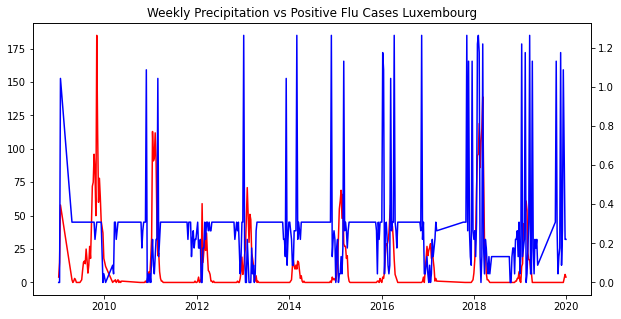

In [88]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(frameon=False)
ax2=ax.twinx()

ax.plot(flu_weatherLux['date'], flu_weatherLux['Count'], color='r')
ax2.plot(flu_weatherLux['date'], flu_weatherLux['totPrecip'], color='b')

# set title
plt.title('Weekly Precipitation vs Positive Flu Cases Luxembourg')

Text(0.5, 1.0, 'Avg Maximum Temp vs Positive Flu Cases Luxembourg')

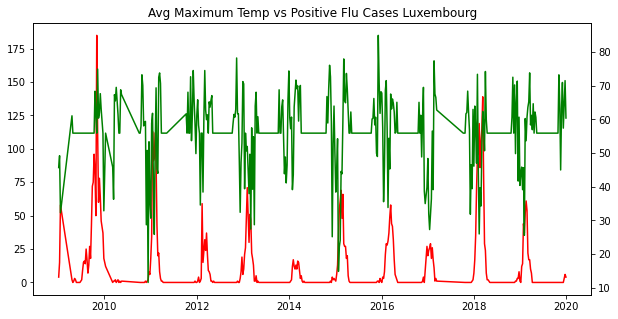

In [89]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(frameon=False)
ax2=ax.twinx()

ax.plot(flu_weatherLux['date'], flu_weatherLux['Count'], color='r')
ax2.plot(flu_weatherLux['date'], flu_weatherLux['avgTmax'], color='g')

# set title
plt.title('Avg Maximum Temp vs Positive Flu Cases Luxembourg')

Text(0.5, 1.0, 'Avg Minimum Temp vs Positive Flu Cases Luxembourg')

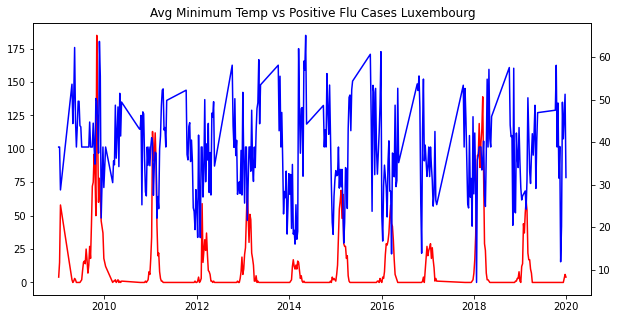

In [90]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(frameon=False)
ax2=ax.twinx()

ax.plot(flu_weatherLux['date'], flu_weatherLux['Count'], color='r')
ax2.plot(flu_weatherLux['date'], flu_weatherLux['avgTmin'], color='b')

# set title
plt.title('Avg Minimum Temp vs Positive Flu Cases Luxembourg')

### Add Malta to our dataset

In [91]:
# variables based on my station search
network = 'GHCND'
ID = 'MT000016597'
station_id = network + ':' + ID
print(station_id)

GHCND:MT000016597


In [92]:
# append additional parameters to data dictionary
data.update({'datatypeid': 'prcp'})
data.update({'startdate': '2019-01-01'})
data.update({'enddate': '2019-12-31'})
data

{'limit': '1000',
 'datasetid': 'GHCND',
 'stationid': 'GHCND:LU000006590',
 'datatypeid': 'prcp',
 'startdate': '2019-01-01',
 'enddate': '2019-12-31'}

In [93]:
# make the request to get our year of data
t = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})

#load the api response as a json
Precip = json.loads(t.text)

#Build the initial dataframe
df=pd.json_normalize(Precip, 'results')

#Rename the column with the values to the datatype and remove the excess values
df=df.rename(columns = {'value':'PRCP'})
df.drop(['attributes','datatype'], axis=1, inplace=True)

In [94]:
df.head()

,date,station,PRCP
0,2019-01-01T00:00:00,GHCND:LU000006590,13
1,2019-01-02T00:00:00,GHCND:LU000006590,0
2,2019-01-03T00:00:00,GHCND:LU000006590,0
3,2019-01-04T00:00:00,GHCND:LU000006590,13
4,2019-01-05T00:00:00,GHCND:LU000006590,6


In [95]:
#Build our dataframe to include the additional required parameters

types = ['tmax','tmin']

for i in types:
    data.update({'datatypeid': i})
    j = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})
    o = json.loads(j.text)
        
    #create new dataframe with api results
    df2 = pd.json_normalize(o, 'results')
    df2=df2.rename(columns = {'value':i})
    df2.drop(['station','attributes','datatype'], axis=1, inplace=True)
    
    #merge the new dataframe with the base one on the date column
    df = pd.merge(df, df2, on=['date'], how='outer')

In [96]:
#Build our our dataframe to include previous years
data.update({'datatypeid': 'prcp'})
dates = ['2018','2017','2016','2015','2014','2013','2012','2011','2010','2009']

for d in dates:
    
    #set the start and end dates
    sd = f'{d}-01-01'
    ed = f'{d}-12-31'
    data.update({'startdate': sd})
    data.update({'enddate': ed})

    #Call to api to get results
    j = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})
    o = json.loads(j.text)
        
    #create new dataframe with api results
    df2 = pd.json_normalize(o, 'results')
    df2=df2.rename(columns = {'value':'PRCP'})
    df2.drop(['attributes','datatype'], axis=1, inplace=True)
    
    #add data for each of the datatypes
    types = ['tmax','tmin']

    for i in types:
        data.update({'datatypeid': i})
        
        #Call to api to get results
        j = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data',params = data, headers = {'token':token})
        o = json.loads(j.text)
        
        #create new dataframe with api results
        df3 = pd.json_normalize(o, 'results')
        df3=df3.rename(columns = {'value':i})
        df3.drop(['station','attributes','datatype'], axis=1, inplace=True)
    
        #merge the new dataframe with the base one on the date column
        df2 = pd.merge(df2, df3, on=['date'], how='outer')
    
    #merge the new dataframe with the base one on the date column
    df = pd.concat([df, df2])

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4017 entries, 0 to 364
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     4017 non-null   object
 1   station  4017 non-null   object
 2   PRCP     4017 non-null   int64 
 3   tmax     4017 non-null   int64 
 4   tmin     4017 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 188.3+ KB


In [98]:
#Create a column with the date
df['datetime']=pd.to_datetime(df['date'])
#Create a column with the week number for the year
df['week']=df['datetime'].dt.isocalendar().week
#then drop the older date column
df.drop(['date'], axis=1, inplace=True)

In [99]:
weatherMal = df

In [100]:
weatherMal.to_csv('weatherMal.csv', index=False)

In [101]:
weatherMal=pd.read_csv('weatherMal.csv')

In [102]:
weatherMal['datetime'] = weatherMal['datetime'].astype('datetime64[ns]')

In [103]:
weatherMal.describe()

,PRCP,tmax,tmin,week
count,4017.000000,4017.000000,4017.000000,4017.000000
mean,54.742096,140.822255,63.466019,26.598706
std,62.961881,85.544755,64.060315,15.061652
min,-150.000000,-80.000000,-150.000000,1.000000
25%,1.000000,73.000000,15.000000,14.000000
50%,49.000000,143.000000,65.000000,27.000000
75%,103.000000,206.000000,114.000000,40.000000
max,419.000000,390.000000,241.000000,53.000000


In [104]:
# we have extraneous precipitation and temperature numbers that need to be addressed based on the highest temps generally
# reaching 100° and the general lows at 40° I am going to keep all values between 40° and 100°. I will change the 
# outliers to NaN and then do a forward fill.

# deal with the minimum values
weatherMal.loc[(weatherMal.PRCP < 0),'PRCP']=0
weatherMal.loc[(weatherMal.tmax < 50),'tmax']=np.nan
weatherMal.loc[(weatherMal.tmin < 40),'tmin']=np.nan

# deal with the maximum values
weatherMal.loc[(weatherMal.PRCP > 1),'PRCP']=np.nan
weatherMal.loc[(weatherMal.tmax > 100),'tmax']=np.nan
weatherMal.loc[(weatherMal.tmin > 80),'tmin']=np.nan

In [105]:
# fill the nan values with the mean value for precipitation
#weatherMal['PRCP'].fillna((weatherMal['PRCP'].mean()), inplace=True)

# Fill the remaining na values utilizing the mean value for each column
weatherMal.fillna(weatherMal.mean(), inplace=True)

C:\Users\eesti\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


In [106]:
weatherMal.describe()

,PRCP,tmax,tmin,week
count,4017.000000,4017.000000,4017.000000,4017.000000
mean,0.044074,75.489933,60.118932,26.598706
std,0.103495,6.182729,5.306876,15.061652
min,0.000000,50.000000,40.000000,1.000000
25%,0.044074,75.489933,60.118932,14.000000
50%,0.044074,75.489933,60.118932,27.000000
75%,0.044074,75.489933,60.118932,40.000000
max,1.000000,100.000000,80.000000,53.000000


In [107]:
# WHO data weeks end on Sunday, so we need to modify the date
weekly_avg = weatherLux.resample('W-Sun', label='right', closed = 'right', on='datetime').mean().reset_index().sort_values(by='datetime')

In [108]:
weekly_avg.rename({'PRCP': 'avgPrecip', 'awnd': 'avgAwnd', 'tmax': 'avgTmax', 'tmin':'avgTmin'}, axis=1, inplace=True)

In [109]:
weekly_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 0 to 574
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   575 non-null    datetime64[ns]
 1   avgPrecip  575 non-null    float64       
 2   avgTmax    575 non-null    float64       
 3   avgTmin    575 non-null    float64       
 4   week       575 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 27.0 KB


In [110]:
weekly_avg['date'] = weekly_avg['datetime']

# Drop the old date column and the week column
weekly_avg.drop(['datetime','week'], axis=1, inplace=True)

In [111]:
# Change avgPrecip to total precipitation for the week
weekly_avg['totPrecip']= weekly_avg.avgPrecip * 7
weekly_avg.drop(['avgPrecip'], axis=1, inplace=True)

In [112]:
weekly_avg.describe()

,avgTmax,avgTmin,totPrecip
count,575.000000,575.000000,575.000000
mean,55.928031,38.845330,0.307908
std,9.554282,9.354592,0.276568
min,11.571429,6.977904,0.000000
25%,55.941176,34.438854,0.176298
50%,55.941176,38.845330,0.308521
75%,59.949580,43.862284,0.308521
max,85.000000,65.120761,2.088149


In [113]:
weekly_avg.isna().sum()

avgTmax      0
avgTmin      0
date         0
totPrecip    0
dtype: int64

In [114]:
flu = pd.read_csv('Mal_Flu.csv')

In [115]:
flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            534 non-null    object 
 1   WHOREGION          534 non-null    object 
 2   FLUREGION          534 non-null    object 
 3   Year               534 non-null    int64  
 4   Week               534 non-null    int64  
 5   SDATE              534 non-null    object 
 6   EDATE              534 non-null    object 
 7   SPEC_RECEIVED_NB   0 non-null      float64
 8   SPEC_PROCESSED_NB  355 non-null    float64
 9   AH1                355 non-null    float64
 10  AH1N12009          355 non-null    float64
 11  AH3                355 non-null    float64
 12  AH5                0 non-null      float64
 13  ANOTSUBTYPED       355 non-null    float64
 14  INF_A              355 non-null    float64
 15  BYAMAGATA          355 non-null    float64
 16  BVICTORIA          355 non

In [116]:
# Drop the columns that are not relevant to our analysis
flu = flu[['Country','EDATE','ALL_INF']].copy()

In [117]:
flu['EDATE'] = flu['EDATE'].astype('datetime64[ns]')

flu['date']=flu['EDATE']
flu.drop(['EDATE', 'Country'], axis=1, inplace=True)

In [118]:
flu_weatherMal=pd.merge(flu, weekly_avg, on=['date'], how='outer')

In [119]:
flu_weatherMal.head()

,ALL_INF,date,avgTmax,avgTmin,totPrecip
0,21.0,2009-10-11,55.941176,38.845330,0.308521
1,0.0,2009-10-18,68.394958,34.812951,0.220372
2,NaN,2009-10-25,61.235294,50.263619,0.264447
3,0.0,2009-11-01,55.941176,49.714286,0.308521
4,0.0,2009-11-08,74.983193,44.285714,0.308521


In [120]:
flu_weatherMal.isna().sum()

ALL_INF      220
date           0
avgTmax        0
avgTmin        0
totPrecip      0
dtype: int64

In [121]:
flu_weatherMal = flu_weatherMal[flu_weatherMal['ALL_INF'].notna()]

In [122]:
# Rename the All_INF column to count
flu_weatherMal = flu_weatherMal.rename(columns={'ALL_INF': 'Count'})

In [123]:
flu_weatherMal.describe()

,Count,avgTmax,avgTmin,totPrecip
count,355.000000,355.000000,355.000000,355.000000
mean,9.605634,55.717552,37.986838,0.295761
std,22.675729,10.816797,10.773371,0.262075
min,0.000000,14.714286,6.977904,0.000000
25%,0.000000,55.899160,30.851237,0.176298
50%,1.000000,55.941176,38.845330,0.308521
75%,6.000000,61.663866,43.862284,0.308521
max,162.000000,85.000000,65.120761,1.264447


Text(0.5, 1.0, 'Weekly Precipitation vs Positive Flu Cases Malta')

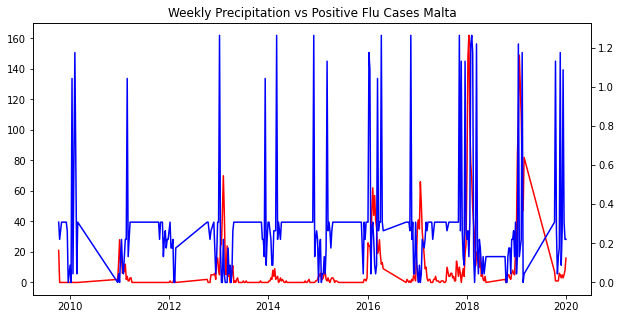

In [124]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(frameon=False)
ax2=ax.twinx()

ax.plot(flu_weatherMal['date'], flu_weatherMal['Count'], color='r')
ax2.plot(flu_weatherMal['date'], flu_weatherMal['totPrecip'], color='b')

# set title
plt.title('Weekly Precipitation vs Positive Flu Cases Malta')

Text(0.5, 1.0, 'Avg Maximum Temp vs Positive Flu Cases Malta')

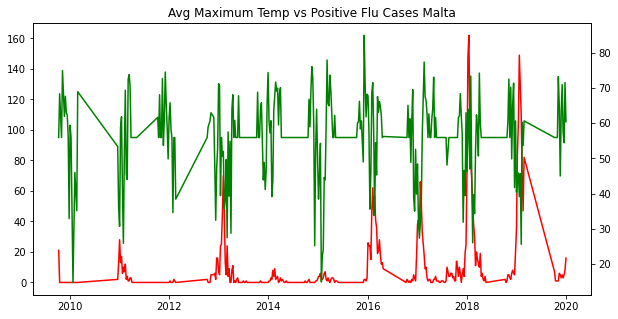

In [125]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(frameon=False)
ax2=ax.twinx()

ax.plot(flu_weatherMal['date'], flu_weatherMal['Count'], color='r')
ax2.plot(flu_weatherMal['date'], flu_weatherMal['avgTmax'], color='g')

# set title
plt.title('Avg Maximum Temp vs Positive Flu Cases Malta')

Text(0.5, 1.0, 'Avg Minimum Temp vs Positive Flu Cases Malta')

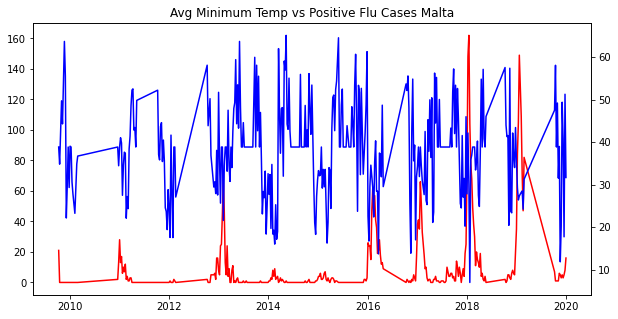

In [126]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(frameon=False)
ax2=ax.twinx()

ax.plot(flu_weatherMal['date'], flu_weatherMal['Count'], color='r')
ax2.plot(flu_weatherMal['date'], flu_weatherMal['avgTmin'], color='b')

# set title
plt.title('Avg Minimum Temp vs Positive Flu Cases Malta')

In [127]:
flu_weather= pd.concat([flu_weatherMal, flu_weatherLux, flu_weatherNY])

In [128]:
flu_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061 entries, 0 to 358
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Count      1061 non-null   float64       
 1   date       1061 non-null   datetime64[ns]
 2   avgTmax    1061 non-null   float64       
 3   avgTmin    1061 non-null   float64       
 4   totPrecip  1061 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 49.7 KB


In [129]:
flu_weather.describe()

,Count,avgTmax,avgTmin,totPrecip
count,1061.000000,1061.000000,1061.000000,1061.000000
mean,398.573987,54.803761,38.346012,6.923314
std,1286.179448,11.554578,10.692107,11.021915
min,0.000000,11.571429,6.977904,0.000000
25%,0.000000,47.571429,30.955809,0.220372
50%,11.000000,55.941176,38.845330,0.308521
75%,95.000000,62.235294,45.714286,20.747178
max,11992.000000,85.000000,65.120761,28.892796


In [130]:
# Export our data frame to a csv to utilize in our analysis
flu_weather.to_csv('flu_weather.csv', index=False)

In [131]:
flu_weatherMal.to_csv('flu_weatherMal.csv', index=False)
flu_weatherLux.to_csv('flu_weatherLux.csv', index=False)
flu_weatherNY.to_csv('flu_weatherNY.csv', index=False)